In [3]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
#data
L= 0.3 # module length in meters
n_f = 6 #number of fibers
i_d = 1.27e-3#internal diameter m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
gamma_w = 32400 #shear rate s-1
Target = 10e-9 #radius 
phi_m = 0.68
eta_0 = 0.001#Pa.second viscosity of hte TGM
rho_p = 1000 #kg/m3 density of the particles
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant
phi_w_guess = [0.64,0.64,0.64] #guess for the volume fraction of solute at the membrane wall
# Particle sizes (in meters)
particles = [
    {'name': '10nm', 'radius': 10e-9, 'phi_b': 0.01},
    {'name': '180nm', 'radius': 180e-9, 'phi_b': 0.05},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.06}
]
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 10e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
eta_f = viscosity_no_PP(eta_0,sum(particles['phi_b'] for particles in particles),9.8)
print(eta_f)
eta_f = 0.0013

#k1 around 10 for spheres
#not sure about the shape factor

def max_agg_packing (phi_m):
    phi_Max=phi_m+0.74*(1-phi_m)
    return phi_Max
phi_M = max_agg_packing(phi_m)
# phi_M = 0.92

#step 3 - maximum back-transport velocity, u (m/s)- Brownian, shear-infuced and intertial lift - Full retention of all solutes
 #particle volume franction at the membrane wall for each particle size for the first iteration
#J_flux = 30 #LMH


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    J = 0.114 * term * math.log(phi_w / phi_b)
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    log_term = math.log(phi_w / phi_b)
    J = 0.078 * term * gamma_w * abs(log_term)
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)


size_vel_dict = {}
set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])

def min_flux(Particles, phi_w_list):
    global set_data  # To ensure you are modifying the global dataframe
    set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])  # Reset dataframe before each call
    
    min_velocity = float('inf')
    selected_particle_radius = None

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Replace or update size_vel_dict
        size_vel_dict[particle['name']] = max_velocity
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data

# Initialize variables for particles and inertial-lift properties
ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            # Use the source to choose the max_velocity
            if source == 'inertial':
                max_velocity = J_inertial(a_particle)
            elif source == 'shear':
                max_velocity = J_shear(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            elif source == 'brownian':
                max_velocity = J_brownian(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            else:
                raise ValueError(f"Unknown source {source} for particle {a_particle}")

            if max_velocity >= 10 * min_velocity and source == 'inertial':
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
                count += 1
            else:
                # Define the objective function based on the source
                def objective_function(phi_w_particle):
                    # Recalculate velocities based on the current wall concentration phi_w_particle
                    if source == 'brownian':
                        max_velocity = J_brownian(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'shear':
                        max_velocity = J_shear(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'inertial':
                        max_velocity = J_inertial(a_particle)
                    return abs(max_velocity - min_velocity)

                # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal
                    phi_w_J_dict[a_particle] = phi_w_optimal
                else:
                    print(f"Optimization failed for particle radius {a_particle:.1e} m")
    
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = phi_M - sum(phi_w_J_dict.values())
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
target_dict = {}
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf= min_flux(Particles, phi_w_list)
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000
    smallest_key = min(phi_w_updated.keys())

    for i in range(max_iterations):
        print("\nInitial Results:")
        print(phi_w_updated)
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != smallest_key}
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[smallest_key] <= 0.74 * (1 - sum(remaining_phiw_j.values())):
            print(f"Iteration {i}: Packing constraints are met.")
            # print("\nFinal Results:")
            # print(f"Pemeation flux: {min_vel:.6f} m/s")
            # for particle in Particles:
            #     name = particle['name']
            #     phi_b = particle['phi_b']
            #     phi_w = phi_w_updated[particle['radius']]
            #     print(f"Particle {name}:")
            #     print(f"  Bulk concentration (phi_b): {phi_b}")
            #     print(f"  Wall concentration (phi_w): {phi_w:.6f}")
            return phi_w_updated,   min_vel, ai_target, dataf
        
        # Store the previous values of phi_w for comparison
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_updated_list = list(phi_w_updated.values())
        #print(phi_w_updated, J_flux, a_target)
        # Recalculate the flux and phi_w_j values after updating
        ai_target, min_vel, dataf= min_flux(particles, phi_w_updated_list)
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)
        # Check for the change in phi_w values between iterations
        target_dict[ai_target] = min_vel
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        if phi_w_diff < tolerance:
            print(f"Iteration {i}: Will not converger further.")
            # print("\nFinal Results:")
            # print(f"Pemeation flux: {min_vel:.6f} m/s")
            # for particle in Particles:
            #     name = particle['name']
            #     phi_b = particle['phi_b']
            #     phi_w = phi_w_updated[particle['radius']]
            #     print(f"Particle {name}:")
            #     print(f"  Bulk concentration (phi_b): {phi_b}")
            #     print(f"  Wall concentration (phi_w): {phi_w:.6f}")
            return phi_w_updated, min_vel, ai_target,dataf
    # If the loop completes without finding a solution
    print("Warning: No solution found within the iteration limit.")
    # print("\nFinal Results:")
    # print(f"Pemeation flux: {min_vel:.6f} m/s")
    # for particle in Particles:
    #     name = particle['name']
    #     phi_b = particle['phi_b']
    #     phi_w = phi_w_updated[particle['radius']]
    #     print(f"Particle {name}:")
    #     print(f"  Bulk concentration (phi_b): {phi_b}")
    #     print(f"  Wall concentration (phi_w): {phi_w:.6f}")

    return phi_w_updated, min_vel, ai_target, dataf

def packing_constraints_2(phi_w_update):

    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000
    smallest_key = min(phi_w_update.keys())

  
    remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_update.items() if a != smallest_key}
    phi_w_i = phi_w_update[ai_target] # Wall concentration of the target particle
    # Check if packing constraints are satisfied
    if (phi_M >= sum(phi_w_update.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_update[smallest_key] <= 0.74 * (1 - sum(remaining_phiw_j.values())):
        print(f" Packing constraints are met.")
        # print("\nFinal Results:")
        # print(f"Pemeation flux: {min_vel:.6f} m/s")
        # for particle in Particles:
        #     name = particle['name']
        #     phi_b = particle['phi_b']
        #     phi_w = phi_w_updated[particle['radius']]
        #     print(f"Particle {name}:")
        #     print(f"  Bulk concentration (phi_b): {phi_b}")
        #     print(f"  Wall concentration (phi_w): {phi_w:.6f}")
        return phi_w_update
    
    # Update phi_w for the target particle
    phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_update.values()))
    phi_w_update[ai_target] = phi_w_i_corrected
    return phi_w_update
        
#
# packing_constraints(particles, phi_w_guess)

# # #step - 8
# phi_smallest_int= phi_w_dict[min(phi_w_dict.keys())] / (1 -sum(phi_w for phi_w in phi_w_dict.values() if phi_w != phi_w_dict[min(phi_w_dict.keys())]))
# print(f"phi_smallest_int: {phi_smallest_int:.6f}")

# # # #step - 9 

# r2_minimum = min(phi_w_dict.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 )
# r_minimum = r2_minimum / 2
# print(f"Minimum transmission gap {min(phi_w_dict.keys())}: {r_minimum} m")


0.00144112


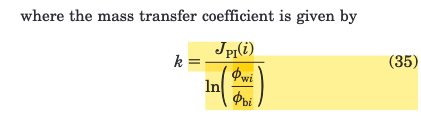

In [7]:
#mass-transfer coefficient#step 10
mass_transfer={}
def sieving_parameters(Particles, phi_w_list):
    phi_w_updated, J_flux,ai_target,dataf =packing_constraints(Particles, phi_w_list)
    # # #step - 8
    phi_smal_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_updated[min(phi_w_updated.keys())]))
    print(f"phi_smallest_int: {phi_smal_int:.6f}")

    # # #step - 9 

    r2_minimum = min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smal_int )) ** (1/3)) - 2 )
    r_min = r2_minimum / 2
    print(f"Minimum transmission gap {min(phi_w_dict.keys())}: {r_min} m")
    S_O_previous = 0
    for i in range(100):
        for particle in Particles:
            a = particle['radius']
            phi_b = particle['phi_b']
            phi_w = phi_w_updated[a]
            mass_transfer_coefficient =(J_flux / math.log((phi_w / phi_b)))
            mass_transfer[a] = mass_transfer_coefficient
            # print(f"Mass transfer coefficient for particle {particle['name']}: {mass_transfer_coefficient} m/s")

        lambda_s_min = target_species /r_min
        # lambda_s_min = 0.963
        print(f"lambda_s_min: {lambda_s_min:.6f}")
        Sieving_coeff_int = ((1 - lambda_s_min ) ** 2 ) * ( 2 - ((1-lambda_s_min) ** 2 )) * math.exp ( - 0.7146 * (lambda_s_min ** 2))
        print(f"Sieving coefficient (int): {Sieving_coeff_int:.6f}")
        delta_m = target_species * ((4 * (4 / 3) * math.pi)/ phi_smal_int) ** (1/3)
        print(f"delta_m: {delta_m}")
        phi_e_K_d = (1 - lambda_s_min ) ** (9/2)
        print(f"phi_e_K_d: {phi_e_K_d:.12f}")
        cake_membrane_porosity = 1 - phi_smal_int
        print(f"cake_membrane_porosity: {cake_membrane_porosity:.6f}")
        diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * target_species)
        print(f"Diffusion coefficient: {diffusion_coeff:.13f}")
        Peclet_m =  ((J_flux * delta_m)/ diffusion_coeff ) *( Sieving_coeff_int /( cake_membrane_porosity * phi_e_K_d))
        print(f"Peclet_m: {Peclet_m:.6f}")
        Sieving_coeff_act = (Sieving_coeff_int * math.exp ( Peclet_m)) / (( Sieving_coeff_int + math.exp ( Peclet_m) )- 1)
        print(f"Sieving coefficient (act): {Sieving_coeff_act:.6f}")
        k= 1.96264E-06
        print(f"k: {k}")
        Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act )* math.exp ( -J_flux / mass_transfer[target_species])+ Sieving_coeff_act)
        print(f"Sieving coefficient (obs): {Sieving_coeff_obs:.6f}")   
        yields = 1 - math.exp (-4 * Sieving_coeff_obs)
        print(f"Yield: {yields:.6f}")
        if (abs(S_O_previous-Sieving_coeff_obs)/((S_O_previous+Sieving_coeff_obs)/2)) <10e-6:
            print(f"Convergence reached after {i} iterations.")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}") 
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")

            return Sieving_coeff_obs, yields, Sieving_coeff_act
        if 0 < Sieving_coeff_obs < 0.75:
            J_flux = mass_transfer[target_species] * math.log((phi_w_updated[target_species] / (Particles[0]['phi_b']* (1 - Sieving_coeff_obs))))
            print(f"Updated flux: {J_flux}")
        S_O_previous = Sieving_coeff_obs
        phi_w_updated=calculate_phi_w(Particles, ai_target, J_flux, dataf)
        print(f"Updated phi_w_dict: {phi_w_updated}")
        phi_w_updated= packing_constraints_2(phi_w_updated)
        ai_target, J_flux, dataf= min_flux(Particles, phi_w_updated.values())
        # phi_w_updated=calculate_phi_w(Particles, ai_target, J_flux, dataf)
        # # #step - 8
        
        phi_smal_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_updated[min(phi_w_updated.keys())]))
        print(f"phi_smallest_int: {phi_smal_int:.6f}")

# # #step - 9 
        r2_minimum = min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smal_int )) ** (1/3)) - 2 )
        r_min = r2_minimum / 2
        print(f"Minimum transmission gap {min(phi_w_updated.keys())}: {r_min} m")
        print(f"Updated phi_w_dict: {phi_w_updated}")
       
    return
print(sieving_parameters(particles, phi_w_guess))



Initial Results:
{1e-08: 0.4840674137554773, 1.8e-07: 0.3518243921125396, 3e-07: 0.2180055013759208}

Initial Results:
{1e-08: 0.1575296567228681, 1.8e-07: 0.3060569568512214, 3e-07: 0.15008348123037626}
Iteration 1: Packing constraints are met.
phi_smallest_int: 0.289651
Minimum transmission gap 1e-08: 1.7346978530296368e-08 m
lambda_s_min: 0.576469
Sieving coefficient (int): 0.257547
delta_m: 3.8674467927470974e-08
phi_e_K_d: 0.020940265506
cake_membrane_porosity: 0.710349
Diffusion coefficient: 0.0000000000168
Peclet_m: 0.277225
Sieving coefficient (act): 0.588939
k: 1.96264e-06
Sieving coefficient (obs): 0.957573
Yield: 0.978297
Updated phi_w_dict: {1e-08: 0.1575296567228681, 1.8e-07: 0.3060569568512214, 3e-07: 0.15008348123037626}
 Packing constraints are met.
phi_smallest_int: 0.289651
Minimum transmission gap 1e-08: 1.7346978530296368e-08 m
Updated phi_w_dict: {1e-08: 0.1575296567228681, 1.8e-07: 0.3060569568512214, 3e-07: 0.15008348123037626}
lambda_s_min: 0.576469
Sieving coe

Mass transfer coefficient for particle 10nm: 2.5212653977231193e-06 m/s
7.485901400221702e-06
Mass transfer coefficient for particle 180nm: 3.836741457151049e-06 m/s
7.485901400221702e-06
Mass transfer coefficient for particle 300nm: 7.581624435478312e-06 m/s

In [6]:
max_i = 100
for i in range(max_i):
    J = mass_transfer[target_species] * math.log((phi_w_dict[target_species] / (particles[0]['phi_b']* (1 - S_O))))
    S_O_previous = S_O
    print("Sieving_Coefficient previous", S_O_previous)
    print("Flux", J)
    S_O = S_A / ((1 - S_A )* math.exp ( -J/ mass_transfer[target_species])+ S_A)
    print("Sieving coefficient", S_O)
    yields = 1 - math.exp (-4 * S_O)
    print("Yields", yields)
    if (abs(S_O_previous-S_O)/((S_O_previous+S_O)/2)) <10e-6:
        print(f"Convergence reached after {i} iterations.")
        print(f"Final Sieving coefficient (obs): {S_O:.6f}")
        print(f"Final Yield: {yields:.6f}") 
        print(f"Final flux: {J:.6f}")
        break


NameError: name 'S_O' is not defined

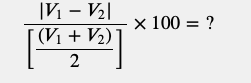

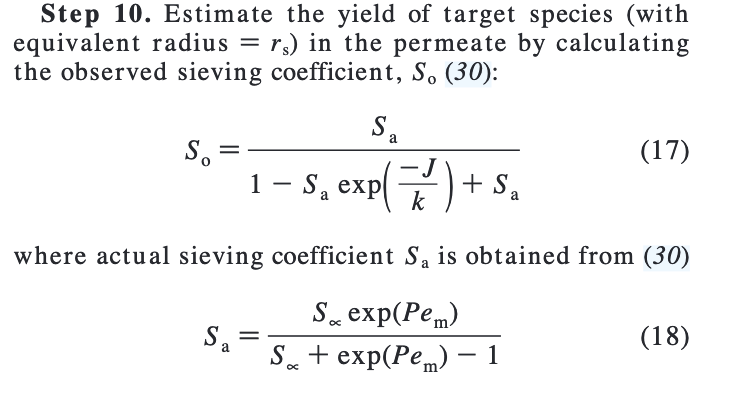
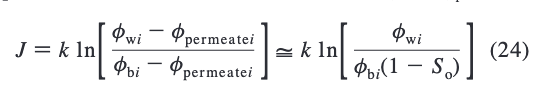